In [260]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib as mpl
import mediapipe as mp
#import easyocr

## Player pose detection

### Defining functions

In [261]:
def blob_detector(img, show=True):
    """simple blob detector using cv2.SimpleBlobDetector with custom parameters"""
    # Set up the detector with default parameters.
    params = cv2.SimpleBlobDetector_Params()
    # Change thresholds
    params.minThreshold = 1;
    params.maxThreshold = 5000;

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 800

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.003
    params.maxConvexity = 0.99

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.01
    params.maxInertiaRatio = 0.4

    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(img)
    print(keypoints)

    # Draw detected blobs as red circles.
    #cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (255,255,20), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
    if show:
        plt.imshow(im_with_keypoints)
        
    return im_with_keypoints, keypoints


def crop_around_blob(img, blobs):
    """cuts a rectangle out of the input img to only contain the blob and its surroundings"""
    bounding_width = 300
    bounding_height = 500

    for blob in blobs:
        x,y = round(blob.pt[0]), round(blob.pt[1])
        left_coord = round(x - (0.5*bounding_width))
        bottom_coord = round(y - (0.5*bounding_height))
        
        cropped = img[bottom_coord:bottom_coord+bounding_height, left_coord:left_coord+bounding_width]
    return cropped, (left_coord,bottom_coord,bounding_width,bounding_height)

def create_small_images_around_blobs(img, blobs, show=False, number=None, save=False):
    """shows the rectangle around blobs[number] and potentially saves it
    img should show only the appropriate region but be in the original quality without filtering/grayscale
    """
    list_of_blobs = []
    list_of_coords = []
    plt.ion()
    if number:
        blob = [blobs[number]]
        try:
            player, coords = crop_around_blob(img, blob)
            plt.imshow(player)
            plt.show()
            
            user_input = input("Would you like to save the image? y/n: ")
            if user_input=="y":
                file_name = input("What should be the file's name?")
                if file_name[-4:] != ".png":
                    file_name = file_name + ".png"
                cv2.imwrite(
                    f'/Users/gergelyfazekas/Documents/python_projects/ocr/blob/{file_name}',
                    player)
            list_of_blobs.append(player)
            list_of_coords.append(coords)
        except:
            print(f"Cannot show blob[{number}]")
    else:
        i=0
        for blob in blobs:
            try:
                player, coords = crop_around_blob(img, [blob])
                plt.imshow(player)
                if show:
                    plt.show()
                    if save:
                        user_input = input("Would you like to save the image? y/n: ")
                        if user_input=="y":
                            file_name = input("What should be the file's name?")
                            if file_name[-4:] != ".png":
                                file_name = file_name + ".png"
                            cv2.imwrite(
                                f'/Users/gergelyfazekas/Documents/python_projects/ocr/blob/{file_name}',
                                player)
                else:
                    if save:
                        cv2.imwrite(
                                f'/Users/gergelyfazekas/Documents/python_projects/ocr/blob/blob_{i}.png',
                                player)
                i+=1
                list_of_blobs.append(player)
                list_of_coords.append(coords)
            except:
                #print(f"Cannot show blob[{number}]")
                pass
            
    return list_of_blobs, list_of_coords
            
def _sharpen_filter(img, **kwargs):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return img

# Players are elongated shapes with consistent color so a sufficiently long kernel might help
def _long_filter(img, kernel_height = 40, kernel_width = 5):
    """applies a simple matrix of ones with shape kernel_height, kernel_width"""
    kernel = np.ones((kernel_height, kernel_width), np.float32) / (kernel_height*kernel_width)
    img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return img

# For smoothing logos, numbers and different colored shapes on players' jersey
def _hole_filter(img, N=5):
    """applies an NxN filter only the outer frame of the matrix has weights and the middle is zero
    e.g. [1,1,1]
         [1,0,1]
         [1,1,1]
    """
    kernel = np.ones((N,N), np.float32)
    kernel[1:-1, 1:-1] = np.zeros((kernel.shape[0]-2,kernel.shape[1]-2))

    kernel = kernel / ((kernel.shape[0])*(kernel.shape[1]))
    kernel[kernel>0] += (1/len(kernel[kernel>0])) * kernel[kernel>0][0]

    img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return img

def filter_img(img, mode="long", show=True, **kwargs):
    """applies a filter specified by the mode argument to the image
    args:
    img: np.array, source image to which the filter is applied
    mode: one of "long", "hole"
    
    kwargs:
    passed to the filter function specified by mode
    """
    if mode=="long":
        filtered = _long_filter(img, **kwargs)
    
    elif mode=="hole":
        filtered = _hole_filter(img, **kwargs)
    
    elif mode=="sharpen":
        filtered = _sharpen_filter(img, **kwargs)
        
    else:
        raise ValueError(f"Invalid argument mode={mode}")
        
    if show:
        plt.imshow(filtered)
    return filtered

def render_rects(img, coord_tuples, default_color=(1,0,1, 0.35)):
    """plots the image with rectangles on it using the coordinates of coord_tuples for the rectangle
    
    args:
    img: np.array, image
    coord_tuples: a list of (x,y,width, height) where (x,y) is the bottom-left corner of the rect
    """
    
    # Create figure with rectangles
    fig, ax = plt.subplots()
    ax.imshow(img)

    for player_coords in coord_tuples:
        try:
            x,y,w,h,color = player_coords
        except ValueError:
            x,y,w,h = player_coords
            color = default_color
        rect_player = mpl.patches.Rectangle((x, y), w, h, color=color)
        ax.add_patch(rect_player)


def detect_players_on_subpictures(img, rects_to_search, hog, show=False):
    """rects_to_search is (x,y,w,h) where we suspect to be a player (but want to double check with HOG)
    this returns the actual coordinates of what the HOG finds, new_x=x+something, new_y=y+something, new_w, new_h
    these coords can be used on the original image original_img[new_y:new_y+new_h, new_x:new_x:new_w]
    """
    refined_coords = []
    for r in rects_to_search:
        x,y,w,h = r
        subpicture = img[y:y+h, x:x+w]
        (coords, _) = hog.detectMultiScale(subpicture, hitThreshold=0.1, winStride=(5, 5),
                                           padding=(1, 1))
        
        if not isinstance(coords, tuple):
            coords = coords.tolist()
            refined_coords.append([x+coords[0][0], y+coords[0][1], coords[0][2], coords[0][3]])
            if show:
                render_rects(subpicture, coords)
    return refined_coords 




### Loading the image

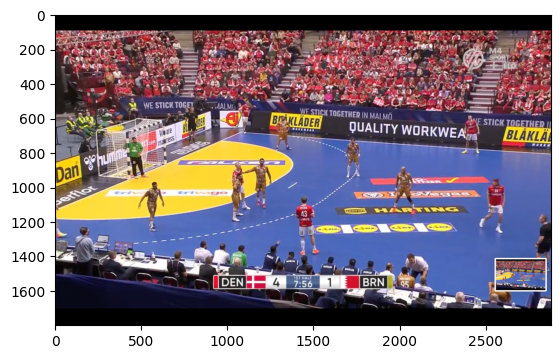

In [262]:
original_img = cv2.imread('img_3.png')

# Convert to RGB
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Show
plt.imshow(original_img)

### Crop image to show appropriate region

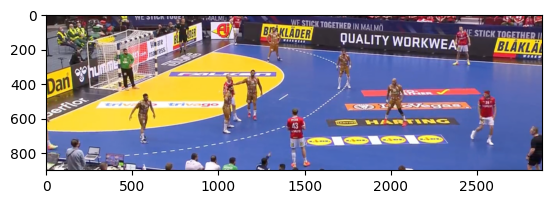

In [263]:
# Crop img to only show the court and players
cropped_img = original_img[510:1410,:]
plt.imshow(cropped_img)

### Applying filters

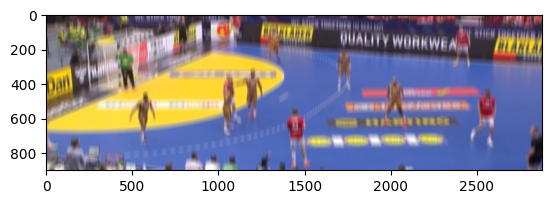

In [264]:
filtered_img = filter_img(cropped_img)

### Change color to grayscale

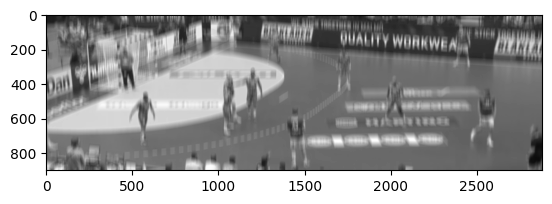

In [265]:
gray = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)

### Threshold to zero

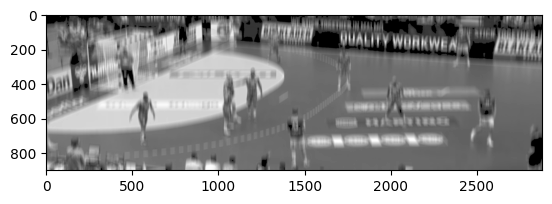

In [266]:
_, threshed_img = cv2.threshold(gray, 50, 255, cv2.THRESH_TOZERO)
plt.imshow(threshed_img, cmap='gray', vmin=0, vmax=255)

### Blob detector

(<KeyPoint 0x2b1fa0cf0>, <KeyPoint 0x2a4c36220>, <KeyPoint 0x2a4c36310>, <KeyPoint 0x2a4c8c1b0>, <KeyPoint 0x2a4c8fea0>, <KeyPoint 0x2a4c8f2d0>, <KeyPoint 0x2a4c8dd70>, <KeyPoint 0x2a4d05ce0>, <KeyPoint 0x2a4d059e0>, <KeyPoint 0x2a4d065e0>, <KeyPoint 0x2a4d066d0>, <KeyPoint 0x2b2003270>, <KeyPoint 0x2b20030f0>, <KeyPoint 0x2b2000540>, <KeyPoint 0x2b2002d60>, <KeyPoint 0x2b20031b0>, <KeyPoint 0x2b2002e20>, <KeyPoint 0x2b2002d30>)


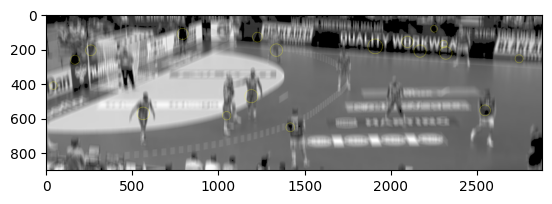

In [267]:
img_with_blobs, blob_keypoints = blob_detector(threshed_img)

### Cut out small images around blobs

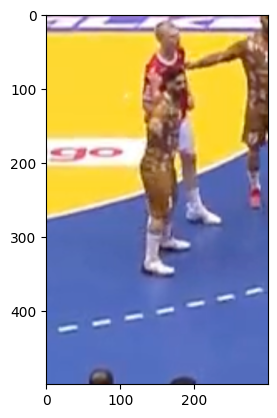

In [268]:
blobs_found, small_image_coords = create_small_images_around_blobs(cropped_img, blob_keypoints)
rect_coordinates_readjusted = [(item[0], item[1]+510, item[2], item[3]) for item in small_image_coords]

### Initialize HOG Descriptor

In [269]:
hog = cv2.HOGDescriptor()  
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) 

### Detect players on the small images

In [270]:
# Detect players using blob 
players_coords_2 = detect_players_on_subpictures(original_img, rect_coordinates_readjusted, hog, show=False)
pink = [(1,0,1,0.35)]
players_coords_2 = [item+pink for item in players_coords_2]

### Detect players on the full image

In [271]:
# Detect players with HOG Descriptor
players_coords_1, _ = hog.detectMultiScale(cropped_img, hitThreshold=0.1,
                                           winStride=(5, 5), padding=(1, 1), scale=1.21)

players_coords_1 = players_coords_1.tolist()
players_coords_1 = [[item[0], item[1]+510, item[2], item[3]] for item in players_coords_1]
green = [(0,1,0,0.3)]
players_coords_1 = [item+green for item in players_coords_1]


### Merge detected player coords: full image + small images

In [272]:
all_players_coords = players_coords_1 + players_coords_2

### Display the result

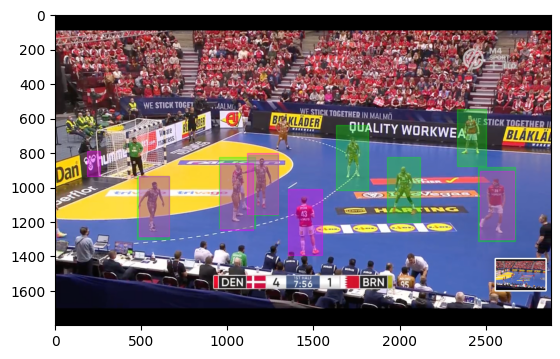

In [273]:
# Green: HOG on full image
# Pink: 1) blob search, 2) create small images, 3) HOG on small images
render_rects(original_img, all_players_coords)

### Pose detection with mediapipe

In [274]:
"""mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# For static images:
IMAGE_FILES = [r'/Users/gergelyfazekas/Documents/python_projects/ocr/goalkeeper.png']
             #r'/Users/gergelyfazekas/Documents/python_projects/ocr/img_2.png',
             #r'/Users/gergelyfazekas/Documents/python_projects/ocr/img_3.png']
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=1,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
    
    for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file)
        image_height, image_width, _ = image.shape
        # Convert the BGR image to RGB before processing.
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if not results.pose_landmarks:
            continue
        print(
            f'Nose coordinates: ('
            f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
            f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
        )

        annotated_image = image.copy()
        # Draw segmentation on the image.
        # To improve segmentation around boundaries, consider applying a joint
        # bilateral filter to "results.segmentation_mask" with "image".
        condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
        bg_image = np.zeros(image.shape, dtype=np.uint8)
        bg_image[:] = BG_COLOR
        annotated_image = np.where(condition, annotated_image, bg_image)
        # Draw pose landmarks on the image.
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        cv2.imwrite(r'/Users/gergelyfazekas/Documents/python_projects/ocr/annotated_image' + str(idx+1) + '.png', annotated_image)
        # Plot pose world landmarks.
        mp_drawing.plot_landmarks(
            results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)"""
            
            
            

'mp_drawing = mp.solutions.drawing_utils\nmp_drawing_styles = mp.solutions.drawing_styles\nmp_pose = mp.solutions.pose\n\n# For static images:\nIMAGE_FILES = [r\'/Users/gergelyfazekas/Documents/python_projects/ocr/goalkeeper.png\']\n             #r\'/Users/gergelyfazekas/Documents/python_projects/ocr/img_2.png\',\n             #r\'/Users/gergelyfazekas/Documents/python_projects/ocr/img_3.png\']\nBG_COLOR = (192, 192, 192) # gray\nwith mp_pose.Pose(\n    static_image_mode=True,\n    model_complexity=1,\n    enable_segmentation=True,\n    min_detection_confidence=0.5) as pose:\n    \n    for idx, file in enumerate(IMAGE_FILES):\n        image = cv2.imread(file)\n        image_height, image_width, _ = image.shape\n        # Convert the BGR image to RGB before processing.\n        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))\n\n        if not results.pose_landmarks:\n            continue\n        print(\n            f\'Nose coordinates: (\'\n            f\'{results.pose_l

### Jersey number recognition with easyocr

In [275]:
"""reader = easyocr.Reader(['en'], gpu=True)
result = reader.readtext(img_2)



numbers = []
for item in result:
    try:
        int(item[1])
        numbers.append(item)
    except ValueError:
        pass
height = numbers[1][0]
height = 48
width = 51
base = (1703,1159)

# Create plot with red rectangles
fig, ax = plt.subplots()
ax.imshow(img_2)
rect = mpl.patches.Rectangle(base, width, height, color=(1,0,0))
ax.add_patch(rect)"""



"reader = easyocr.Reader(['en'], gpu=True)\nresult = reader.readtext(img_2)\n\n\n\nnumbers = []\nfor item in result:\n    try:\n        int(item[1])\n        numbers.append(item)\n    except ValueError:\n        pass\nheight = numbers[1][0]\nheight = 48\nwidth = 51\nbase = (1703,1159)\n\n# Create plot with red rectangles\nfig, ax = plt.subplots()\nax.imshow(img_2)\nrect = mpl.patches.Rectangle(base, width, height, color=(1,0,0))\nax.add_patch(rect)"